## Installing uv

To start, you'll want to have uv installed:

https://docs.astral.sh/uv/getting-started/installation/


**Next, run this in the terminal, from the parent directory:**

    uv sync


Now you will have the kernel used to run this notebook

---

## Running the Required Servers

You need to run **three servers**, each in its own terminal:

- `central_server.py`
- `AS_server_AtomBlastTwin.py`
- `Ceos_server_twin.py`

### 1. Activate the Virtual Environment

`uv` should have created a `.venv` directory for you.

**On macOS / Linux:**

    source .venv/bin/activate

**On Windows (likely):**

    source .venv/Scripts/activate

You should now see the environment activated.

---

### 2. Start the Servers

**Terminal 1 — Central Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.protocols.central_server

**Terminal 2 — Atom Resolution Simulation Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.AS_server_AtomBlastTwin

**Terminal 3 — CEOS Twin Server**

    source .venv/bin/activate
    python -m asyncroscopy.servers.Ceos_server_twin

---

You're now ready to run this notebook! 🚀

In [1]:
import sys
import ast
import numpy as np
sys.path.insert(0, '../')
from asyncroscopy.clients.notebook_client import NotebookClient
from asyncroscopy.utils import parula_color_map
import matplotlib.pyplot as plt
from skimage.feature import blob_log
from scipy.ndimage import gaussian_filter
import pyTEMlib
from pyTEMlib import probe_tools as pt
from scipy.ndimage import gaussian_filter
from skimage.feature import blob_log
from pyTEMlib.atom_tools import atom_refine

%matplotlib ipympl

### Connections:

In [2]:
# Connect the Client to the central (async) server
tem = NotebookClient.connect(host='localhost',port=9000)

# Tell the central server address of all connected instruments
routing_table= {"AS": ("localhost", 9001),
                "Gatan": ("localhost", 9002),
                "Ceos": ("localhost", 9003),
                "Preacquired_AS": ("localhost", 9004)}
tem.send_command('Central',"set_routing_table", routing_table)

# ConnectionResetError: [Errno 54] Connection reset by peer 
# in terminal, type:
# lsof -i :9000
# then kill PIDs on that port


Connecting to central server localhost:9000...
Connected to central server.


'[Central] Routing table updated'

In [3]:
# connect to the AutoScript computer and initialize microscope
tem.send_command('AS',command='connect_AS',args={'host':'localhost','port':9001})
tem.send_command(destination = 'Ceos', command = 'getInfo', args = {})

'CEOS Digital Twin Server'

### Setting the aberrations from known values:

In [5]:
aberrations = pt.get_target_aberrations("Spectra300", 200000)
aberrations['C23a'] = 10
aberrations['C23b'] = 10
tem.send_command(destination = 'Ceos', command = 'uploadAberrations', args = aberrations)
pt.print_aberrations(aberrations)

### Get an image:

simulated with pystemsim inside the AS_server_SimAtomRes (working with the Ceos server)

In [62]:
tem.send_command('AS', 'load_sample')


'Loaded sample with 3600 atoms. Dose map initialized.'

'Current atom count: 3600'

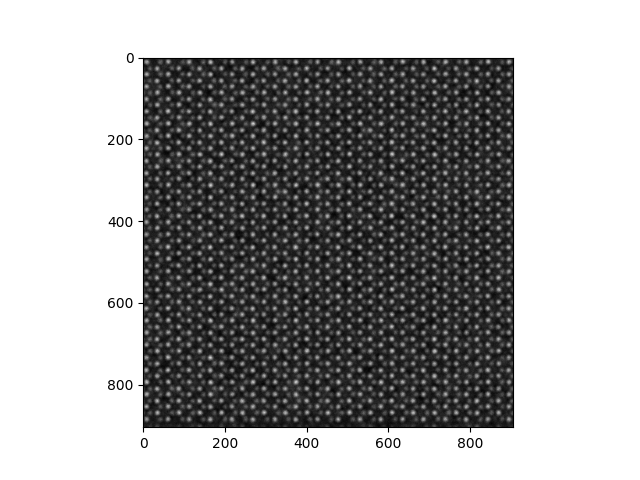

In [63]:
image_args = {'scanning_detector':'HAADF',
                'size':512,
                'dwell_time':10e-6}

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img, cmap="gray")
tem.send_command('AS', 'get_atom_count', {})

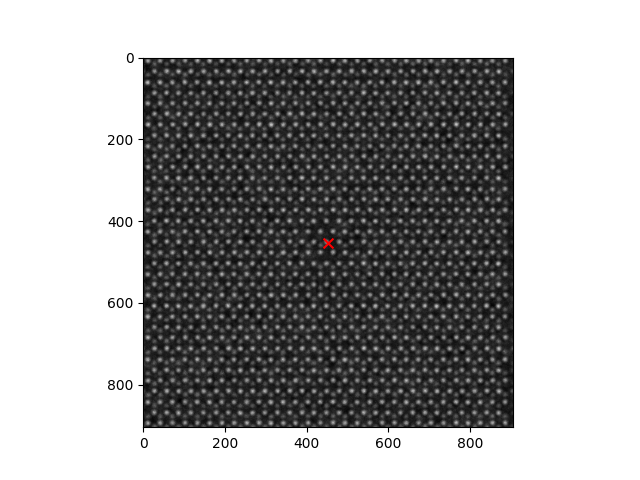

In [64]:
# Position beam and expose
beam_pos = [0.5, 0.5] # move beam around 

beam_current = 100000 # change beam current for hole drilling
tem.send_command('AS', 'place_beam', {'x': beam_pos[1], 'y': beam_pos[0]})
tem.send_command('AS', 'set_beam_current', {'current': beam_current})
tem.send_command('AS', 'unblank_beam', {'duration': 1}) # seconds

beam_current = 1
tem.send_command('AS', 'set_beam_current', {'current':beam_current}) # pA
img = tem.send_command('AS','get_scanned_image', image_args)

plt.figure()
plt.imshow(img.T, cmap="gray")
plt.scatter(beam_pos[1] * img.shape[1], beam_pos[0] * img.shape[0], color='red', s=50, marker='x')


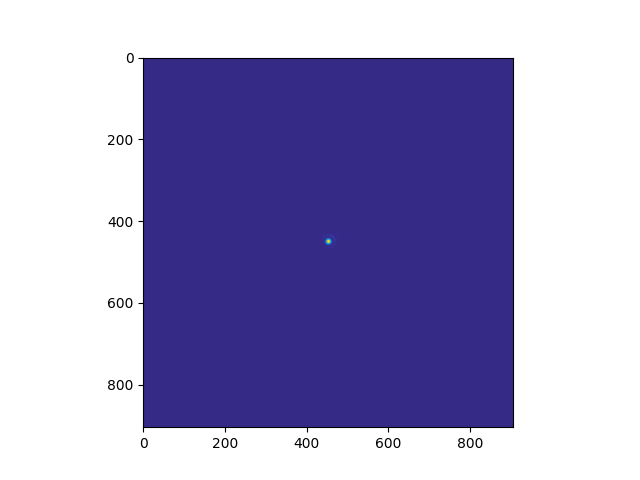

In [65]:
dose_map = tem.send_command('AS', 'get_dose_map', {})

plt.figure()
plt.imshow(dose_map, cmap=parula_color_map)

/Users/austin/Documents/GitHub/asyncroscopy/.venv/lib/python3.12/site-packages/pyTEMlib/atom_tools.py:181: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  [pout, _] = scipy.optimize.leastsq(gauss_difference, guess, args=area)


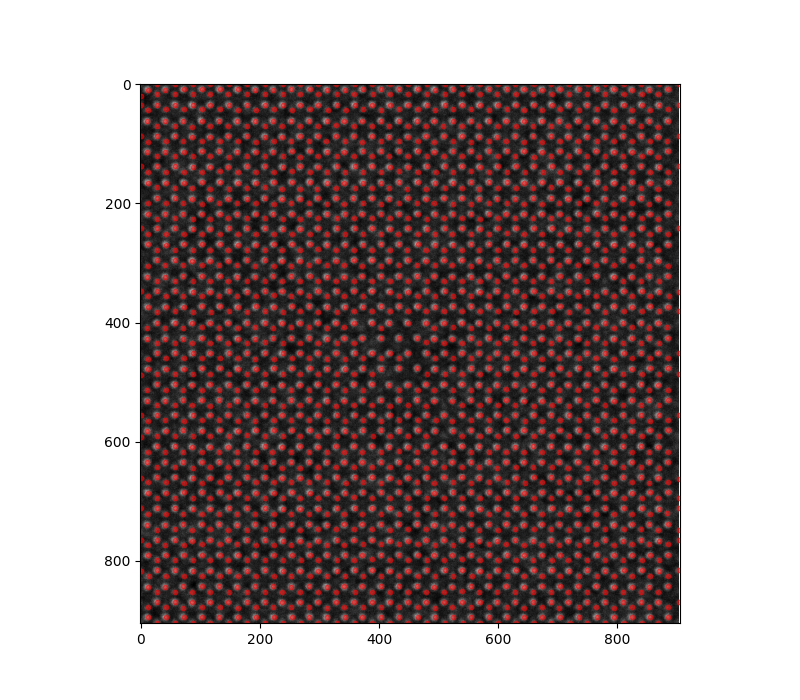

In [66]:
blurred = gaussian_filter(img, sigma=1)
blobs = blob_log(blurred, max_sigma=3, threshold=0.05)

fig, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
ax.imshow(img.T, cmap='gray')
ax.scatter(blobs[:, 0], blobs[:, 1], c='r', s=10, alpha = .5)
atom_radius = 3 
sym = atom_refine(img, blobs, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])
intensities = np.array(sym['intensity_area'])

to_delete = np.where(intensities < 0)
refined_atoms = np.delete(refined_atoms, to_delete, axis=0)
intensities = np.delete(intensities, to_delete, axis=0)

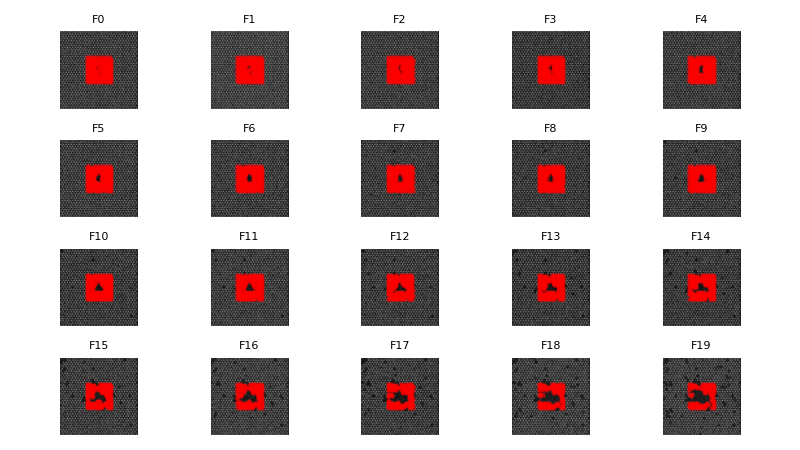

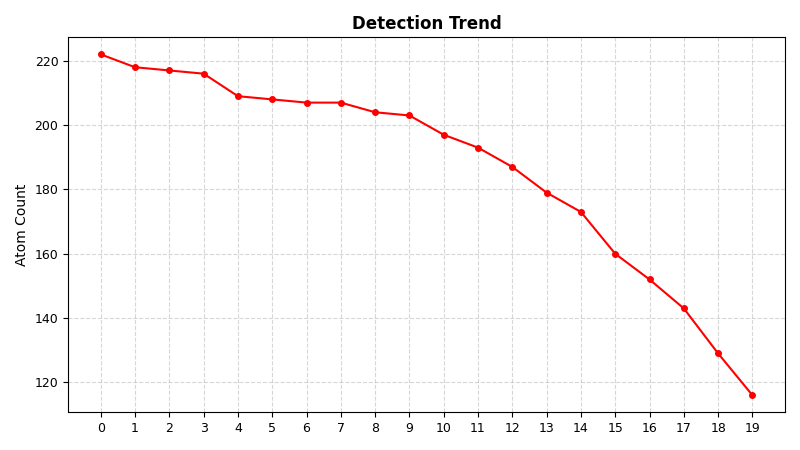

In [67]:
n_frames = 20
beam_current = 1000 # imaging current
tem.send_command('AS', 'set_beam_current', {'current': beam_current}) 

fig, ax = plt.subplots(4, 5, figsize=(8, 4.5)) 
ax = ax.ravel()

blob_count = []
atoms_per_frame = []
intensities_per_frame = []
for frame in range(n_frames):
    img = tem.send_command('AS', 'get_scanned_image', image_args)

    # get atoms
    blurred = gaussian_filter(img, sigma=1)
    blobs = blob_log(blurred, max_sigma=3, threshold=0.05)


    # keep just the middle
    H, W = img.shape
    x = blobs[:, 0]
    y = blobs[:, 1]
    mask_middle = (
        (x > W / 3) & (x < 2 * W / 3) &
        (y > H / 3) & (y < 2 * H / 3)
    )

    atom_radius = 3  
    sym = atom_refine(img, blobs[mask_middle], atom_radius, max_int=0, min_int=0, max_dist=2)
    refined_atoms = np.array(sym['atoms'])
    intensities = np.array(sym['intensity_area'])

    to_delete = np.where(intensities < 0)
    refined_atoms = np.delete(refined_atoms, to_delete, axis=0)
    intensities = np.delete(intensities, to_delete, axis=0)
    intensities_per_frame.append(intensities)
    blob_count.append(len(refined_atoms))
    atoms_per_frame.append(refined_atoms)

    ax[frame].imshow(img.T, cmap='gray')
    ax[frame].scatter(refined_atoms[:, 0], refined_atoms[:, 1], c='r', s=5, alpha=0.5) 
    ax[frame].set_title(f"F{frame}", fontsize=8) 
    ax[frame].axis('off')
fig.tight_layout()


fig, ax = plt.subplots(1, 1, figsize=(8, 4.5)) 

ax.plot(range(n_frames), blob_count, marker='o', color='red', linewidth=1.5, markersize=4)
ax.set_ylabel('Atom Count', fontsize=10)
ax.set_title('Detection Trend', fontsize=12, fontweight='bold')
ax.set_xticks(range(n_frames))
ax.tick_params(labelsize=9)
ax.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()


In [113]:
from scipy.spatial import cKDTree

# --- First frame ---
atoms0 = atoms_per_frame[0]

# Build KD-tree
tree0 = cKDTree(atoms0)

# Query 2 nearest neighbors (self + nearest)
dists, idxs = tree0.query(atoms0, k=2)

# Nearest-neighbor distances (exclude self at index 0)
nn_distances = dists[:, 1]

# Define cutoff
nn_cutoff = 1.1 * np.median(nn_distances)

print(f"Median NN distance (frame 0): {np.median(nn_distances):.3f}")
print(f"NN cutoff: {nn_cutoff:.3f}")

neighbor_norm = []   # normalized coordination per frame
for f, atoms in enumerate(atoms_per_frame):
    if len(atoms) == 0:
        neighbor_norm.append(np.array([]))
        continue

    intensities = intensities_per_frame[f]
    tree = cKDTree(atoms)
    neighbors = tree.query_ball_point(atoms, r=nn_cutoff)
    nns = np.array([len(nbrs) - 1 for nbrs in neighbors]) # raw NN counts (exclude self)
    norm = np.where(intensities < 13, 3.0, 6.0)
    neighbor_norm.append(1-(norm-nns/norm))

Median NN distance (frame 0): 16.646
NN cutoff: 18.310


In [114]:
Xs, Ys, Zs, Cs = [], [], [], []

for f, (atoms, cnorm) in enumerate(zip(atoms_per_frame, neighbor_norm)):
    if len(atoms) == 0:
        continue

    Xs.append(atoms[:, 0])
    Ys.append(atoms[:, 1])
    Zs.append(np.full(len(atoms), f))
    Cs.append(cnorm)

Xs = np.concatenate(Xs)
Ys = np.concatenate(Ys)
Zs = np.concatenate(Zs)
Cs = np.concatenate(Cs)

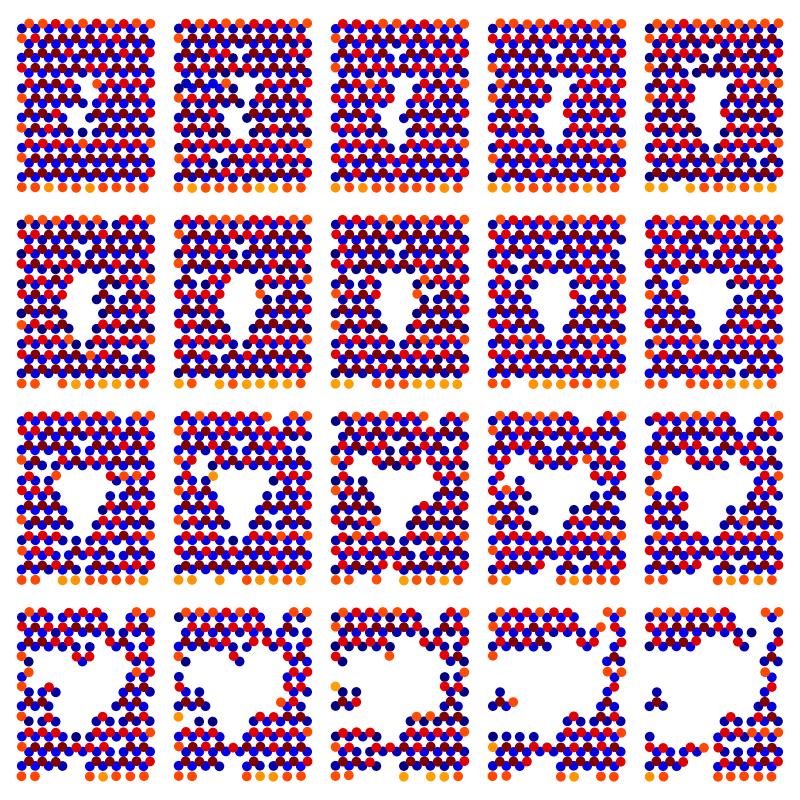

In [115]:
fig, ax = plt.subplots(4, 5, figsize=(8,8)) 
ax = ax.ravel()

for f, (atoms, cnorm) in enumerate(zip(atoms_per_frame, neighbor_norm)):
    ax[f].scatter(atoms[:, 0], atoms[:, 1],c=cnorm,cmap='jet') 
    ax[f].axis('off')
fig.tight_layout()

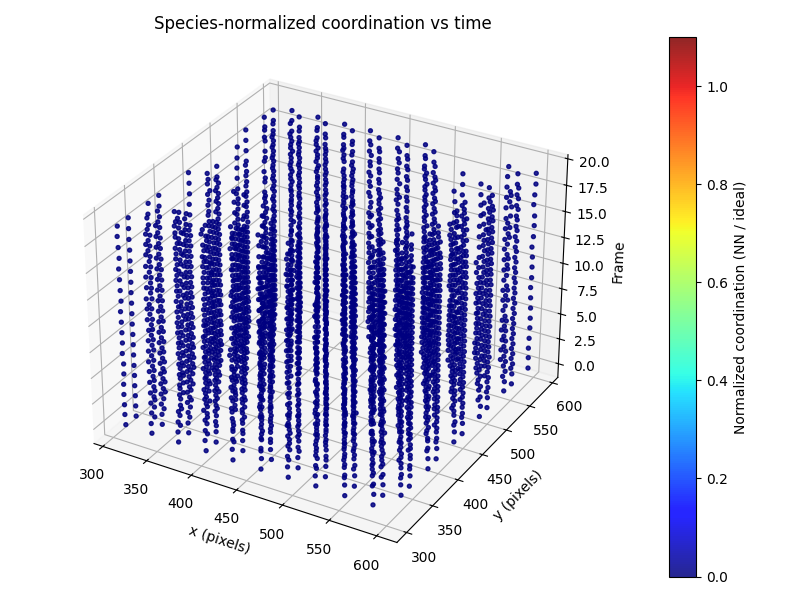

In [116]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    Xs, Ys, Zs,
    c=Cs,
    cmap='jet',
    vmin=0,
    vmax=1.1,
    s=8,
    alpha=0.85
)

ax.set_xlabel("x (pixels)")
ax.set_ylabel("y (pixels)")
ax.set_zlabel("Frame")

cb = plt.colorbar(sc, ax=ax, pad=0.1)
cb.set_label("Normalized coordination (NN / ideal)")

plt.title("Species-normalized coordination vs time")
plt.tight_layout()